In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 20 17:33:48 2018

@author: jens

Simulate a spatio-temporal Hawkes process on [0,2pi]x[0,infty) with periodic bdry conditions in space.
"""

import numpy as np
import random as rand
#import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.optimize as opt
from RandomNumberGen import draw_random_number_from_pdf
from scipy.optimize import fmin

#
rand.seed(42)

class Spatio_Temporal_Hawkes_Process():

    def __init__(self, Base, spatial, temporal, monotone_temporal_kernel = False):
        self.Base = Base
        self.spatial = spatial
        self.temporal = temporal
        self.Events = np.array([[0],[0]])
        self.PoissEvent = np.array([])
        self.Sim_num = 0
        self.monotone_temporal_kernel = monotone_temporal_kernel
        
        if monotone_temporal_kernel is not True:
            self.temporal_extremum = fmin(lambda t: -self.temporal(t), 0, disp = False);
        
        
    def propogate_by_amount(self, k, Space = [-np.pi, np.pi]):        
        
        
        def periodizer(x):
            return (x- np.pi)%(2*np.pi)-np.pi
        
        def periodized_spatial(x):
            return self.spatial(periodizer(x))
            
        def positive_periodized_spatial(x):
            return max(periodized_spatial(x),0)
        
        for i in range(k):
            self.PoissEvent = np.append(self.PoissEvent,rand.expovariate(1))
        
        PoissProcess = np.cumsum(self.PoissEvent)
        mu = quad(self.Base, Space[0], Space[1])[0]   
        
        for time in PoissProcess[self.Sim_num:]:   
            
            T = self.Events[0,-1]
            
            
            dist_temporal = lambda t: np.array([self.temporal(t-time) for time in self.Events[0,:] 
                                                if time < t and time != 0])
            
            dist_periodized_spatial = lambda x,t: np.array([periodized_spatial(x - location) 
                                                for location in self.Events[1,:] 
                                                       if self.Events[0,self.Events[1,:] == location] < t])
        
            positive_periodized_spatial = lambda x,t: np.array([max(0,periodized_spatial(x - location)) 
                                                for location in self.Events[1,:] 
                                                       if self.Events[0,self.Events[1,:] == location] < t])
                     
            positive_int_spatial = lambda t: np.array([quad(positive_periodized_spatial
                                                  , Space[0] - location, Space[1]-location)[0] 
                                                       for location in self.Events[1,:] 
                                                       if self.Events[0,self.Events[1,:] == location] < t])
            
            
            '''
            Problematic approach for time, because it makes up most of the computation load. Solving
            an equation of that complexity does not seem to be too feasible. 
            Change this appraoch to thinning of a projected Hawkes process on the time line.
            In each step, initialize a Hawkes process from Hawkes_Thinning_class and perform one step 
            based on the integrated time intensity.
            '''
            
            def Space_free_temporal_at_time_t(t):
                
                At_t_dist_periodized_spatial = lambda x: dist_periodized_spatial(x ,t)

                At_t_full_intensity = lambda x: max(0, self.Base(x) + np.multiply(dist_temporal(t),At_t_dist_periodized_spatial(x)).sum())

                At_t_integrated_intensity = quad(At_t_full_intensity, Space[0], Space[1])[0]

                return  At_t_integrated_intensity
            
            ''' 
            Find upper bound M(t|H_t) for the intensity. Adjusted to kernels with one global extremum = maximum 
            '''
            
            def upper_bound_M(t):
                
                if t - self.Events[0,-1] < self.temporal_extremum:
                    return Space_free_temporal_at_time_t(t) + self.temporal(self.temporal_extremum)
                else:
                    return Space_free_temporal_at_time_t(t)
        
            while True:
                if self.monotone_temporal_kernel is True:
                    upper_bd = Space_free_temporal_at_time_t(T)
                else:
                    upper_bd = upper_bound_M(T)

                u = np.random.rand(1)
                tau = -np.log(u)/upper_bd
                T = T + tau
                s =  np.random.rand(1)

                if s <=  Space_free_temporal_at_time_t(T)/upper_bd:
                    EventTime = T
                    break 
            
#             print('time')
            
#             def righthandside(t):
#                 dydt = mu + np.multiply(positive_int_spatial(t),dist_temporal(t)).sum() 
#                 return dydt
            
#             if len(self.Events[0,:]) > 1:
#                 I = lambda x: quad(righthandside, self.Events[0,-1], x)[0]  - (time - PoissProcess[np.roll(PoissProcess == time,-1)])
#                 EventTime = opt.fsolve(I, self.Events[0,-1])
#             else: 
#                 I = lambda x: quad(righthandside, 0, x)[0]  - time 
#                 EventTime = opt.fsolve(I, 0)
            
#             print('time done')
            
            Stopped_dist_periodized_spatial = lambda x: dist_periodized_spatial(x ,EventTime)
            
            Stopped_full_intensity = lambda x: max(0, self.Base(x) + np.multiply(dist_temporal(EventTime),Stopped_dist_periodized_spatial(x)).sum())
            
            Norm_Stopped_full_intensity = quad(Stopped_full_intensity, Space[0], Space[1])[0]
            
            Spatial_density = lambda x: max(0,self.Base(x) + np.multiply(dist_temporal(EventTime),np.array([periodized_spatial(x - location) 
                                                                                                       for location in self.Events[1,:] 
                                                                                                        if self.Events[0,self.Events[1,:]==location] < EventTime])).sum())/Norm_Stopped_full_intensity
            
            print('space')
              
            y = [Spatial_density(item) for item in np.linspace(-np.pi,np.pi,100)]
            
            plt.plot(np.linspace(-np.pi,np.pi,100), y)
            plt.show()
            
            EventSpace = draw_random_number_from_pdf(Spatial_density, [-np.pi,np.pi])
            
            
            print('space done')
            NewEvent = np.array([EventTime, EventSpace])
            self.Events = np.append(self.Events, NewEvent, axis = 1)
        
        if self.Sim_num == 0:
            self.Events = self.Events[:,1:]
        
        self.Sim_num += k

In [2]:
# from HawkesClass import Hawkes
import numpy as np
import matplotlib.pyplot as plt

#the temporal kernel
def HawkesIntensity_temporal(time):
    a = 0.9 
    b = 2 
    IndInTemp = (time < b/2) & (time > 0)
    IndDecTemp = (time >= b/2) & (time < b)
    return 2*a/b * (time)*IndInTemp + ((-(2*a)/b)* (time) + 2*a )*IndDecTemp
 

#the spatial kernel    
def h(space):
#     a = 1.5
    b = np.pi
    Ind = ((space + b/2) >= 0) & ((space + b/2) <= b)
    return (504/(5*np.pi**4)*space**4  -146/(5*np.pi**2)*space**2 + 1)*Ind

def Base(x):
    mu = 0.5
    return mu


#  -------------- Plotting the kernels
x = np.linspace(0,np.pi,100)

plt.subplot(1, 2, 1)
plt.plot(x, HawkesIntensity_temporal(x), 'm')
plt.xlabel('time')
plt.ylabel('temporal kernel over time')


plt.subplot(1, 2, 2)
plt.plot(x - np.pi/2, h(x - np.pi/2), 'r') # Only for plot reasons, h is symmetric around 0
plt.xlabel('space')
plt.ylabel('spatial kernel on X')

plt.tight_layout()

plt.show()

# -------------- Creating an instance of the Hawkes Class

<Figure size 640x480 with 2 Axes>

# Short Simulation

In [ ]:
G = Spatio_Temporal_Hawkes_Process(Base, h, HawkesIntensity_temporal)

0
space


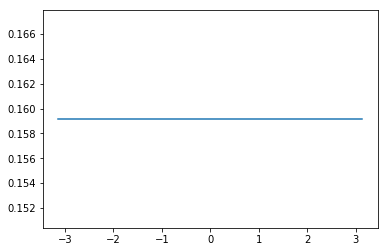

space done
1
space


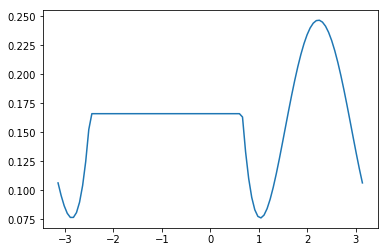

space done
2
space


/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



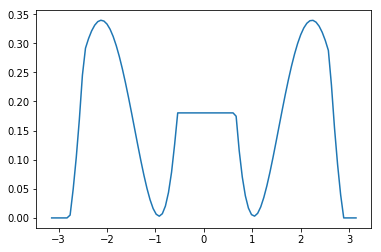

space done
3
space


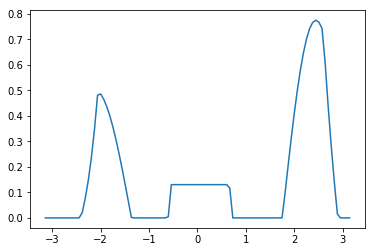

space done
4
space


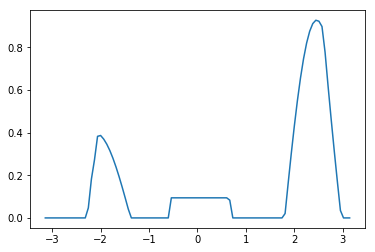

space done
5
space


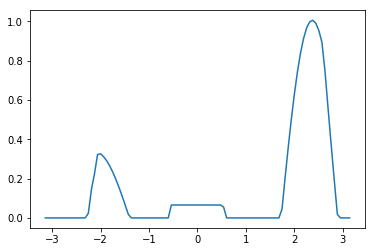

space done
6
space


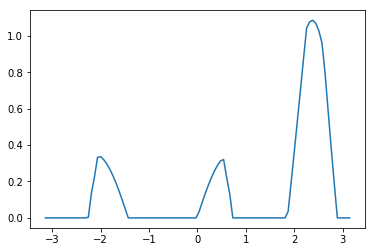

space done
7
space


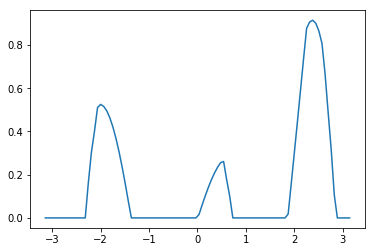

space done
8
space


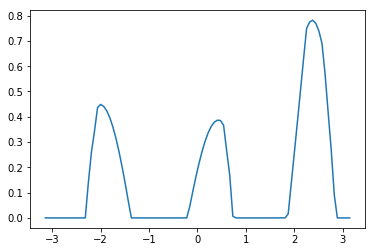

space done
9
space


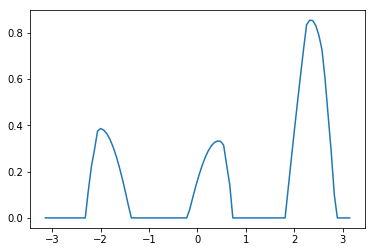

space done
10
space


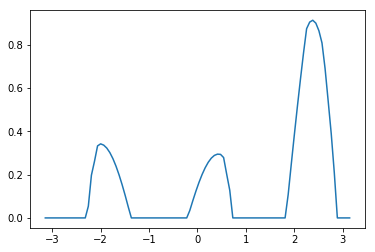

space done
11
space


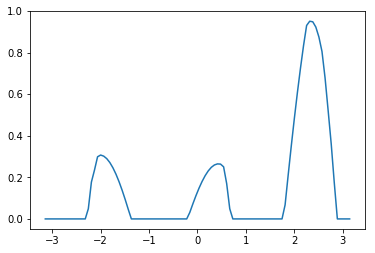

space done
12
space


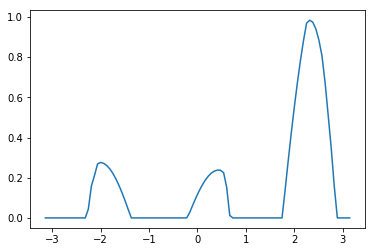

space done
13
space


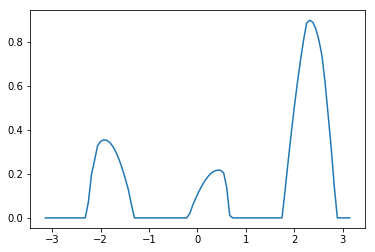

space done
14
space


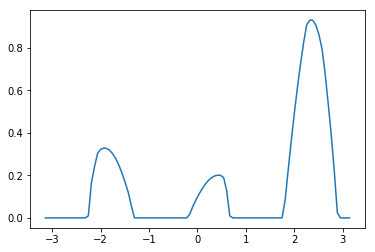

space done
15
space


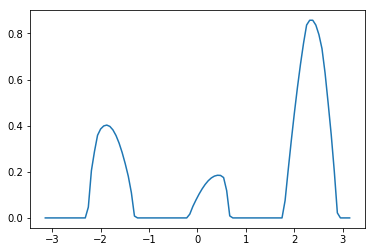

space done
16
space


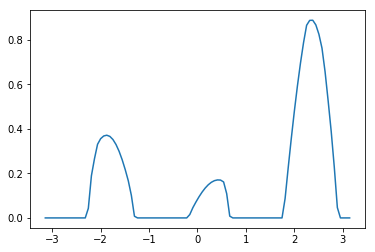

space done
17
space


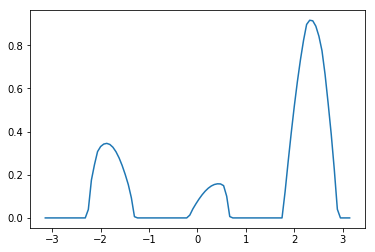

space done
18
space


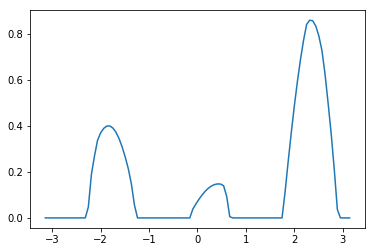

space done
19
space


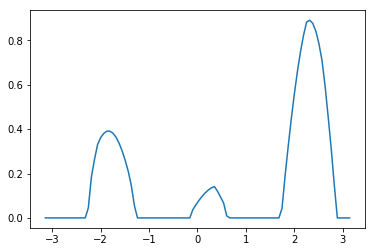

space done
20
space


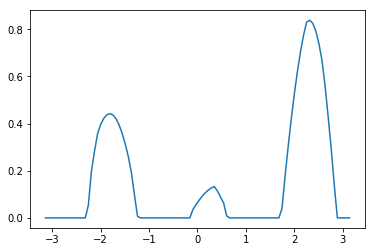

space done
21
space


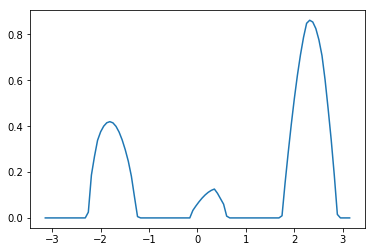

space done
22
space


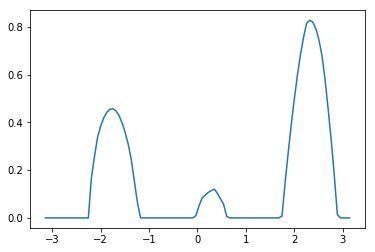

space done
23
space


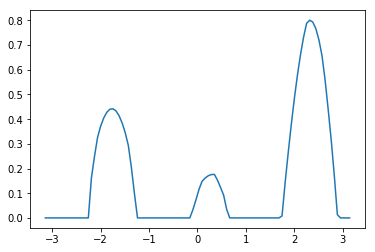

space done
24
space


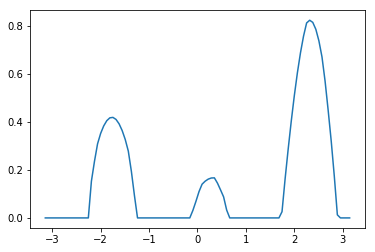

space done
25
space


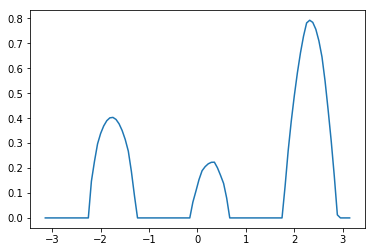

space done
26
space


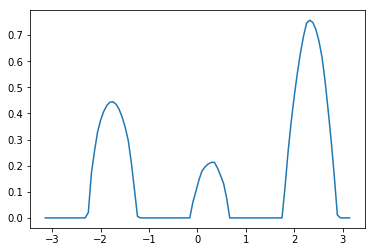

space done
27
space


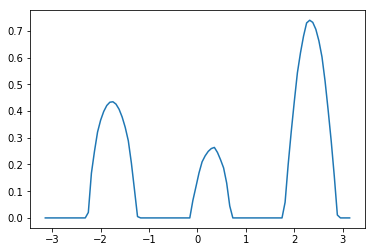

space done
28
space


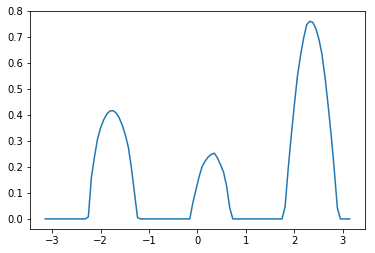

space done
29
space


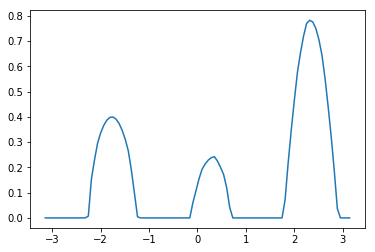

space done


In [4]:
steps = 30

for i in range(steps):
    print(i)
    G.propogate_by_amount(1)    

In [5]:
def periodizer(x):
    return (x- np.pi)%(2*np.pi)-np.pi


def intensity(time,space):
    t = np.array([G.temporal(time-item) for item in G.Events[0,:] if item < time])
    s = np.array([G.spatial(periodizer(space-item)) for item in G.Events[1,:] if G.Events[0,G.Events[1,:] == item] < time])
    return 0.5+ np.multiply(t,s).sum()


inten = np.vectorize(intensity)

In [6]:
import plotly
import plotly.graph_objs as go
import itertools
import numpy as np

time = np.linspace(0,G.Events[0,-1],200)
time = np.append(time, G.Events[0,:])
time.sort()

space = np.linspace(-np.pi,np.pi,200)
space = np.append(space, G.Events[1,:])
space.sort()

time_grid, space_grid = np.meshgrid(time, space, sparse = True)

z = inten(time_grid, space_grid)

In [7]:
data = [
    go.Surface(
        x = time,
        y = space,
        z=z
    )
]

layout = go.Layout(
    title='Parameter-surface',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
    
    
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='Parameter_surface_quot.html')


trace = [go.Heatmap(z=z,
                   x = time,
                   y = space,
                   colorscale = 'Jet'
                   ),
        go.Scatter(
        x = G.Events[0,:],
        y = G.Events[1,:],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(255, 182, 193, .9)',
            line = dict(
                width = 2,
                )
            )
        )        
]

layout = go.Layout(
    title='Space-Time Intensity Heatmap',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Space (Circle)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

data_heat= trace

fig = go.Figure(data=data_heat, layout=layout)

plotly.offline.plot(fig, filename='Heatmap_Hawkes_Process_intensity_with_scattered_Events_short.html')

'file:///home/jens/Dokumente/Hawkes-Processes/Spatio-Temporal-Hawkes-Proc-and-Appl/Spatio-Temporal-Hawkes-Proc-and-Appl/Parameter_heatmap_exp.html'

# Long Simulation

In [3]:
H = Spatio_Temporal_Hawkes_Process(Base, h, HawkesIntensity_temporal)

0
space


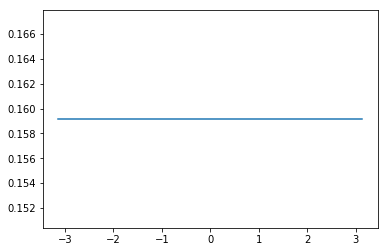

space done
1
space


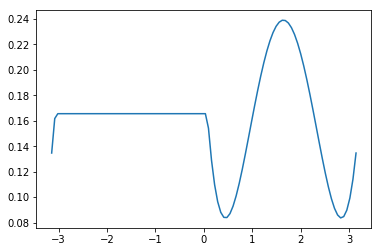

space done
2


/home/jens/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


space


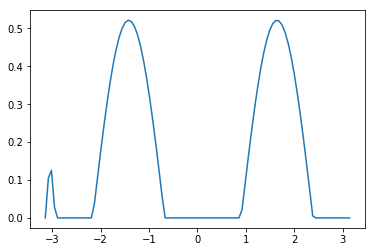

space done
3
space


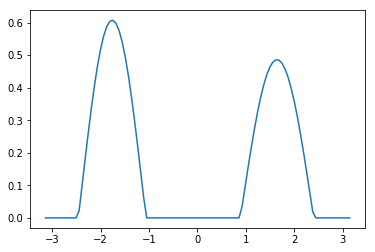

space done
4
space


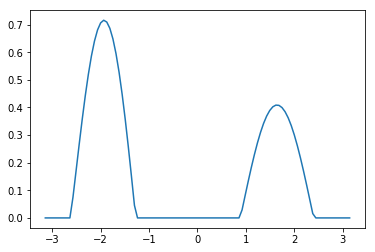

space done
5
space


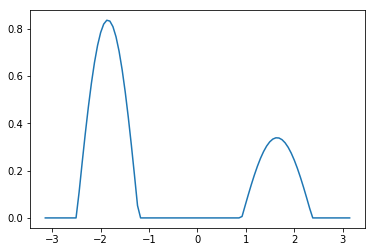

space done
6
space


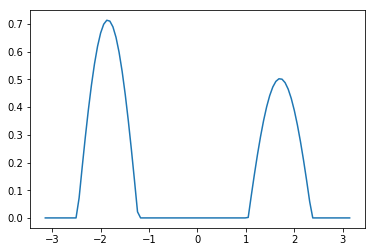

space done
7
space


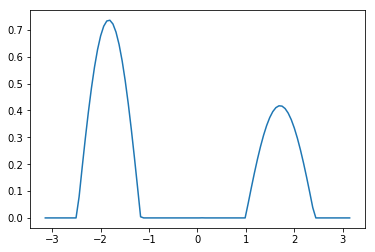

space done
8
space


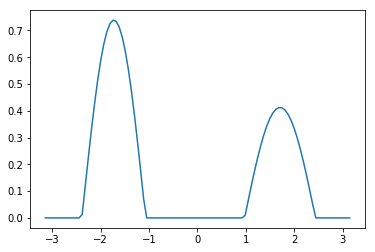

space done
9
space


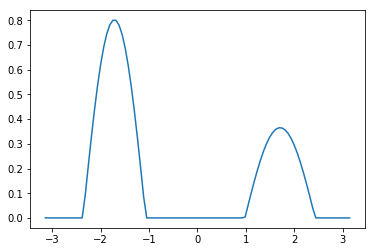

space done
10
space


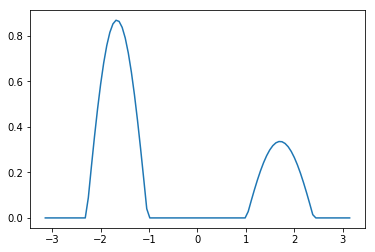

space done
11
space


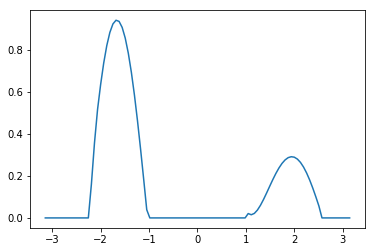

space done
12
space


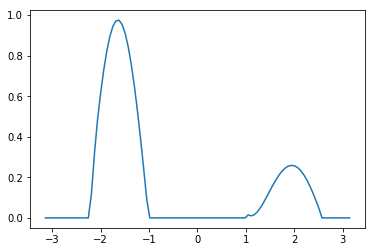

space done
13
space


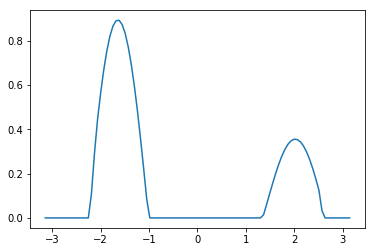

space done
14
space


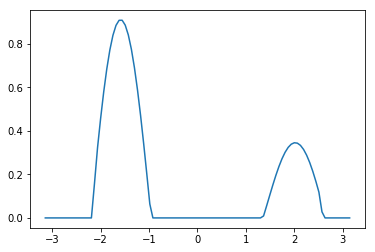

space done
15
space


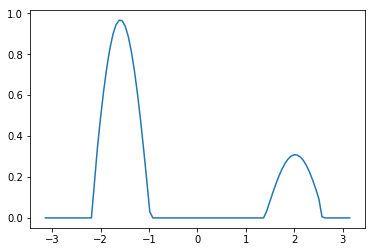

space done
16
space


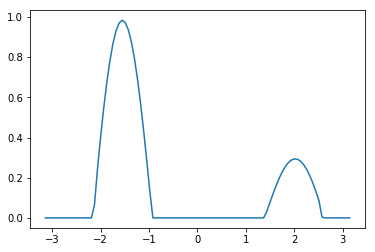

space done
17
space


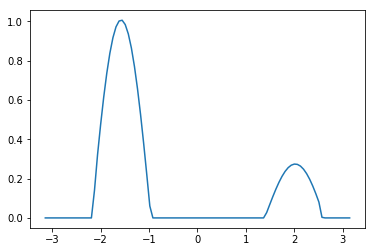

space done
18
space


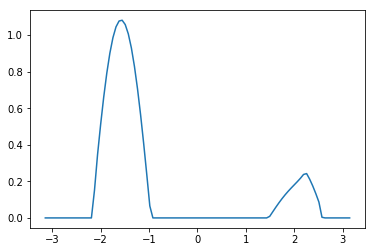

space done
19
space


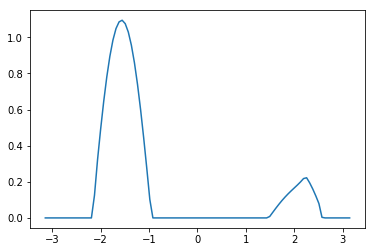

space done
20
space


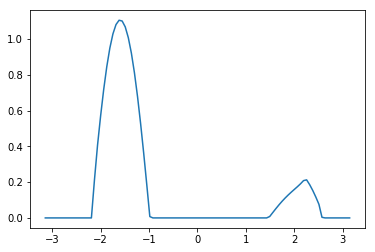

space done
21
space


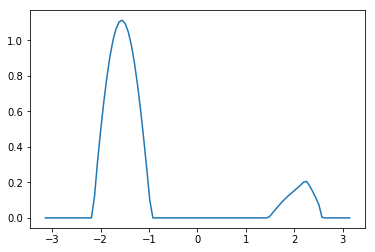

space done
22
space


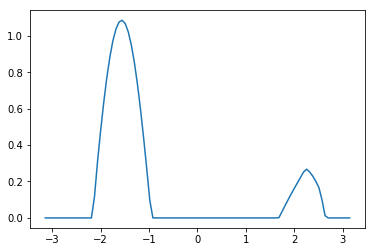

space done
23
space


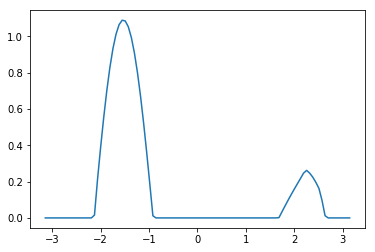

space done
24
space


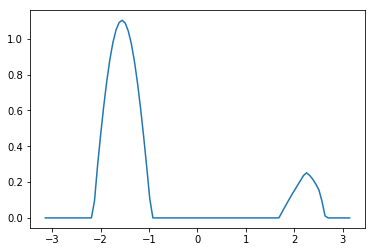

space done
25
space


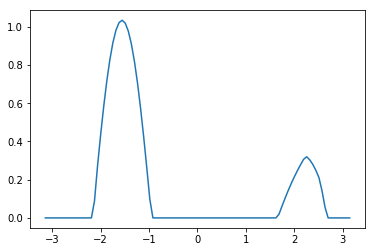

space done
26
space


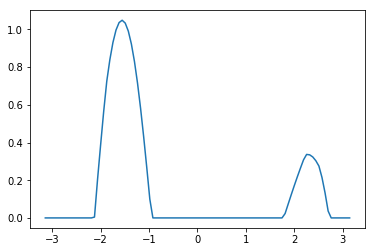

space done
27
space


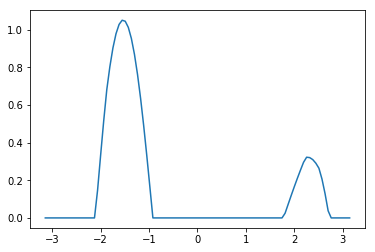

space done
28
space


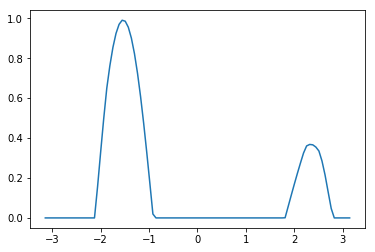

space done
29
space


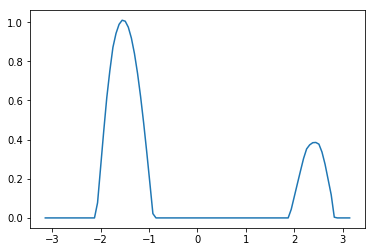

space done
30
space


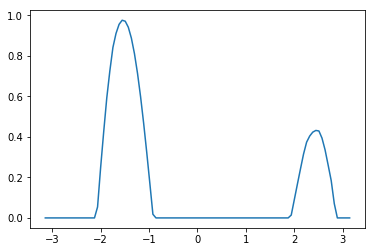

space done
31
space


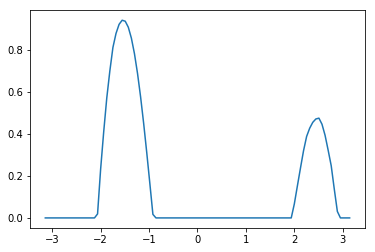

space done
32
space


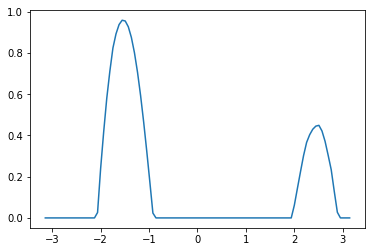

space done
33
space


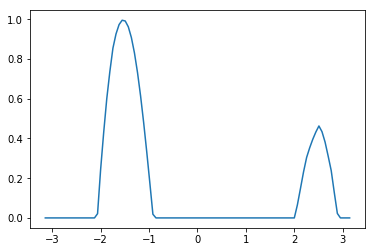

space done
34
space


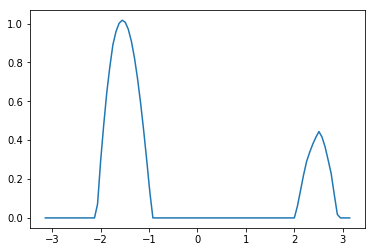

space done
35
space


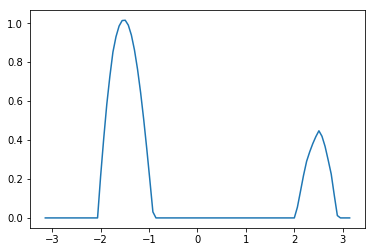

space done
36
space


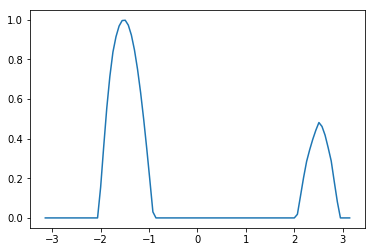

space done
37
space


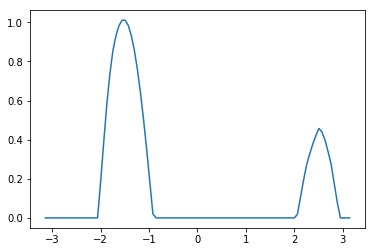

space done
38
space


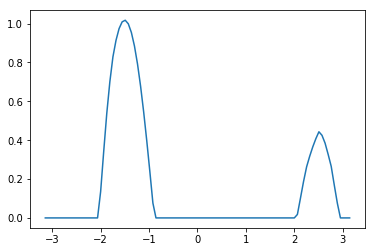

space done
39
space


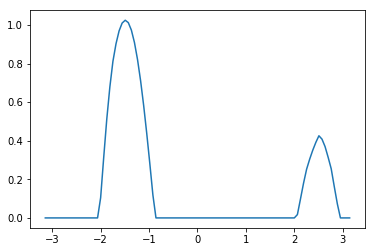

space done
40
space


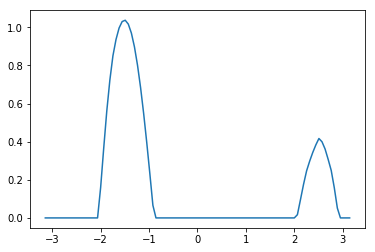

space done
41
space


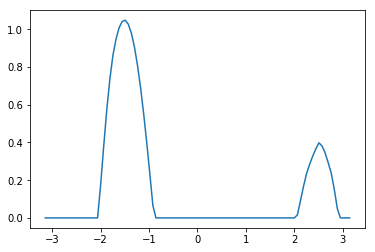

space done
42
space


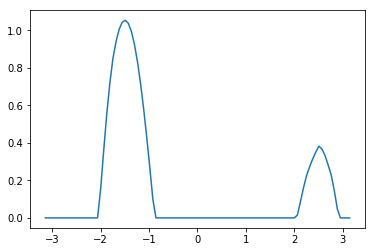

space done
43
space


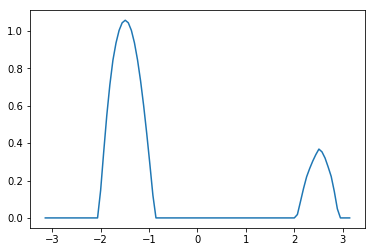

space done
44
space


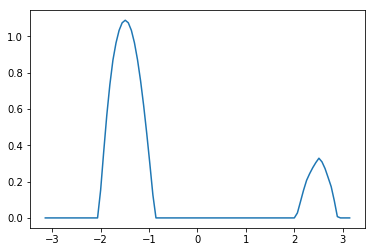

space done
45
space


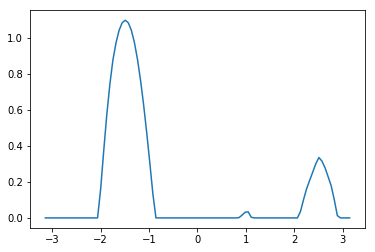

space done
46
space


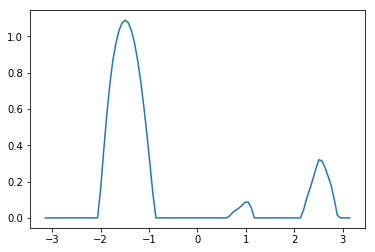

space done
47
space


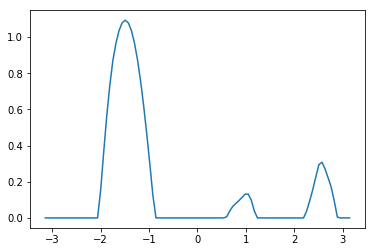

space done
48
space


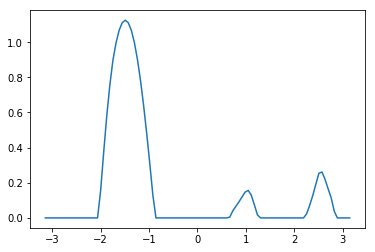

space done
49
space


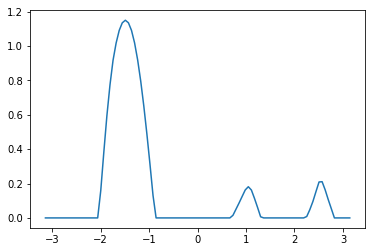

space done
50
space


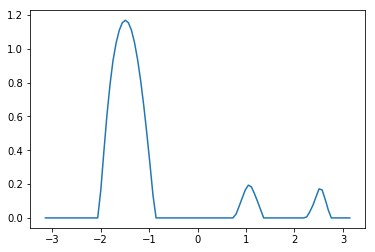

space done
51
space


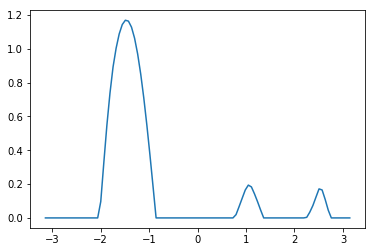

space done
52
space


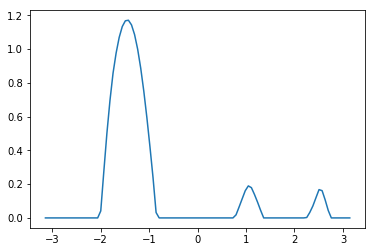

space done
53
space


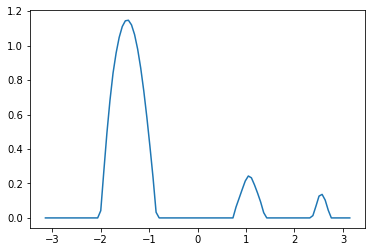

space done
54
space


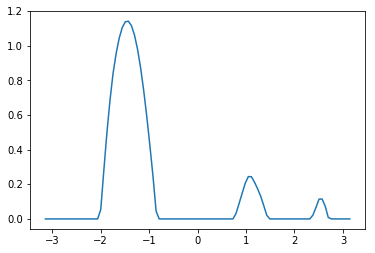

space done
55
space


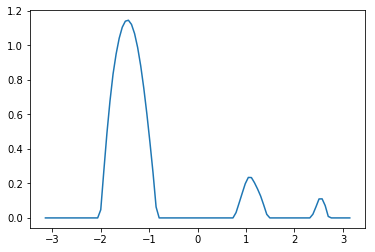

space done
56
space


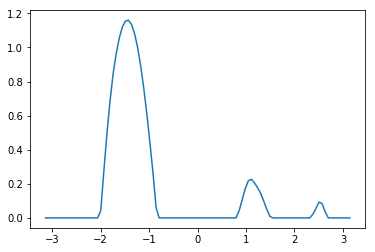

space done
57
space


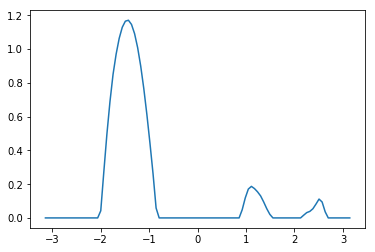

space done
58
space


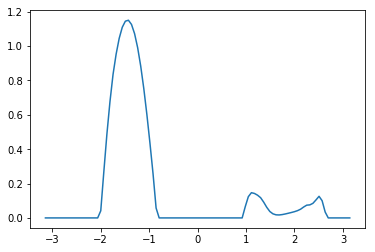

space done
59
space


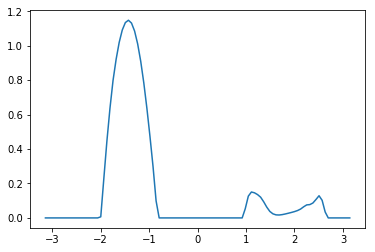

space done
60
space


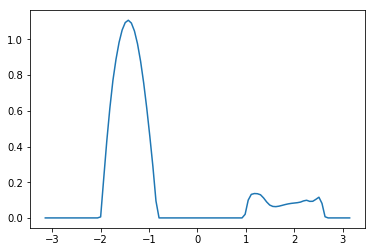

space done
61
space


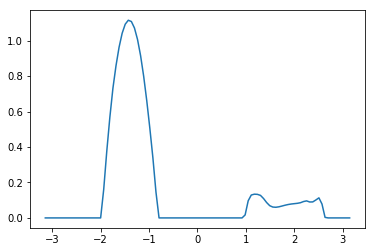

space done
62
space


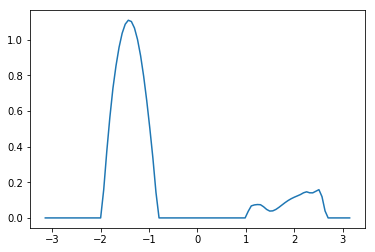

space done
63
space


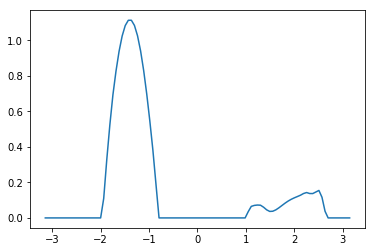

space done
64
space


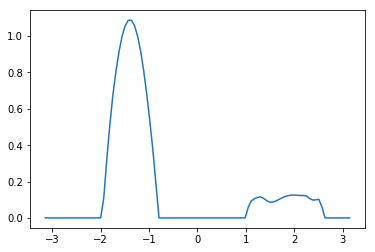

space done
65
space


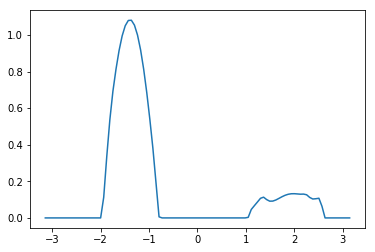

space done
66
space


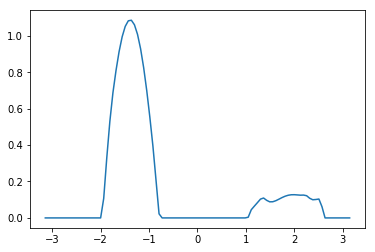

space done
67
space


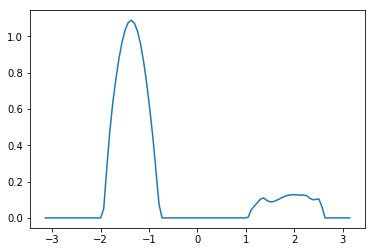

space done
68
space


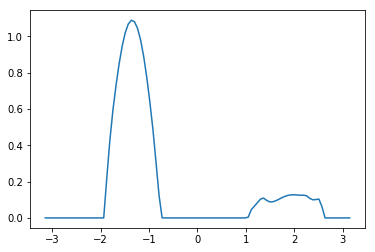

space done
69
space


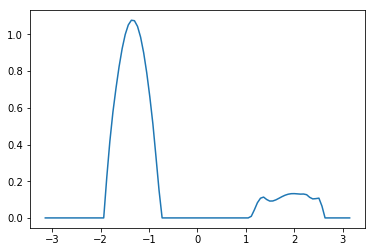

space done
70
space


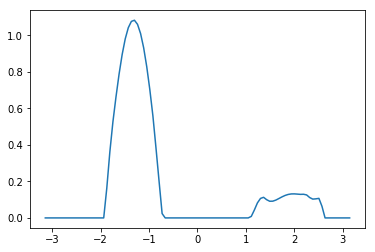

space done
71
space


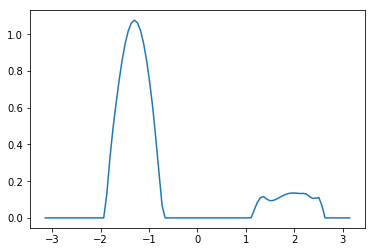

space done
72
space


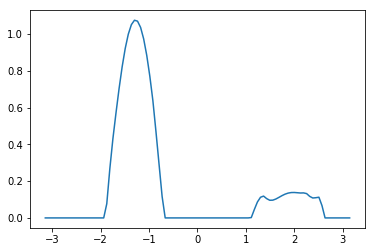

space done
73
space


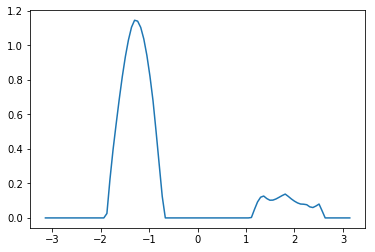

space done
74
space


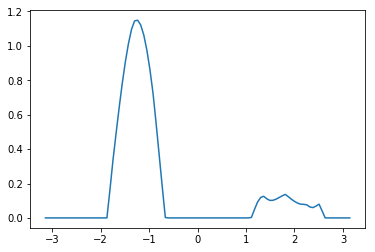

space done
75
space


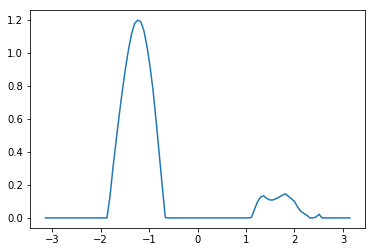

space done
76
space


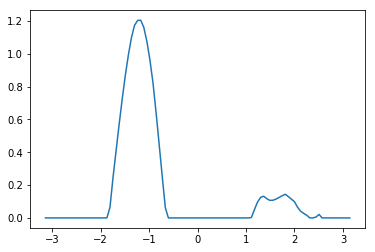

space done
77
space


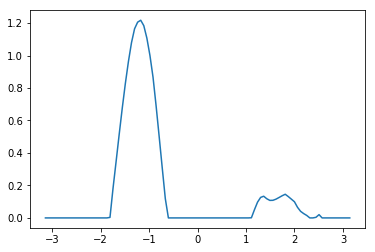

space done
78
space


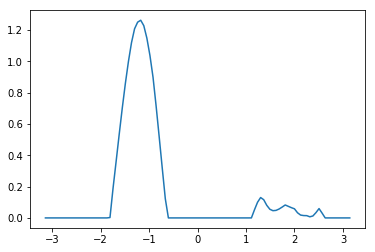

space done
79
space


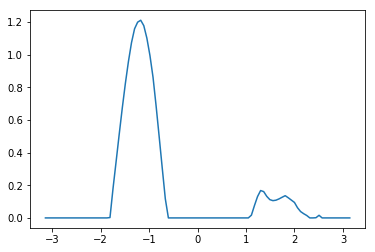

space done
80
space


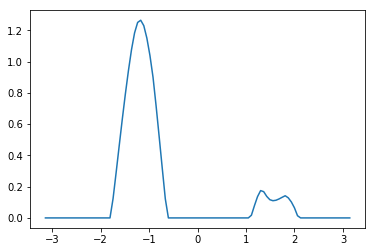

space done
81
space


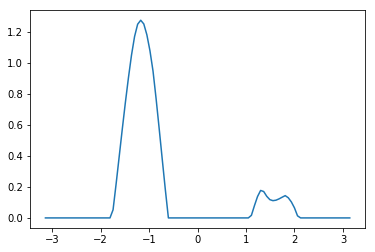

space done
82
space


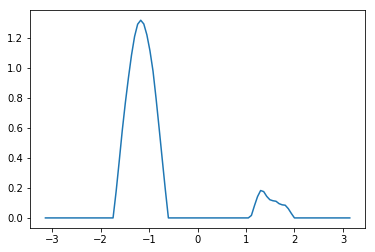

space done
83
space


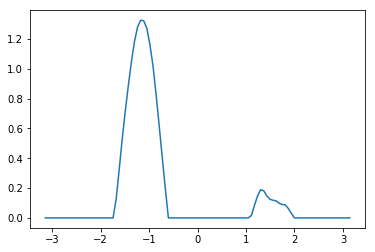

space done
84
space


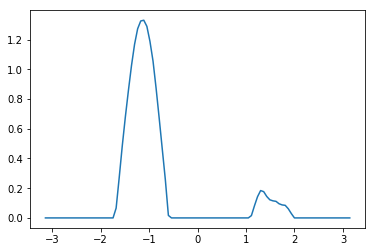

space done
85
space


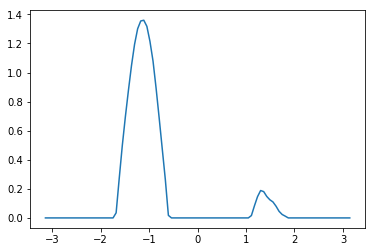

space done
86
space


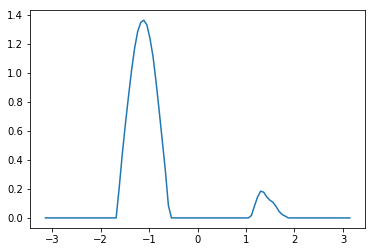

space done
87
space


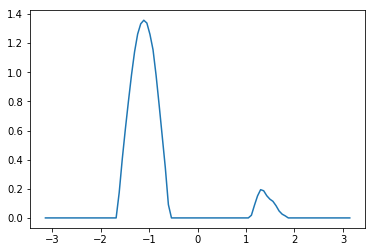

space done
88
space


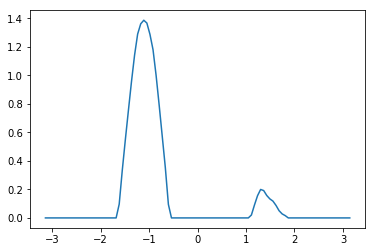

space done
89
space


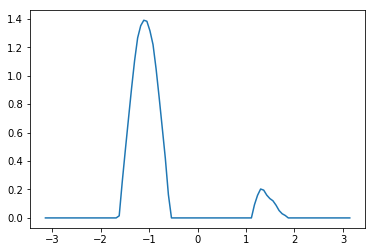

space done
90
space


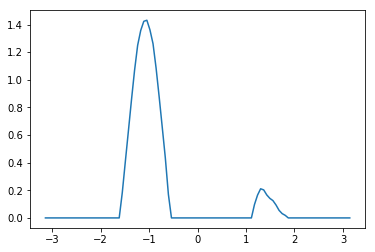

space done
91
space


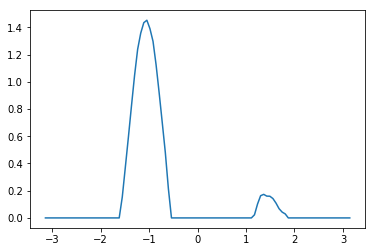

space done
92
space


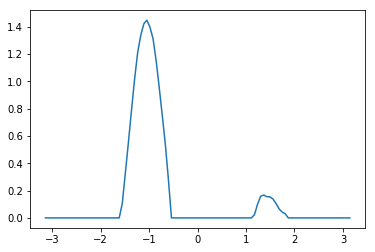

space done
93
space


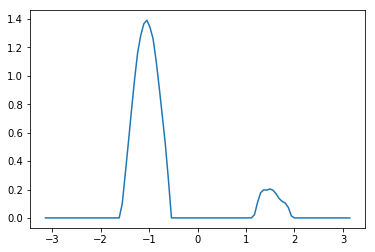

space done
94
space


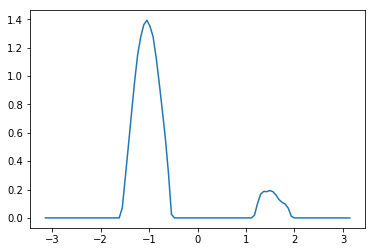

space done
95
space


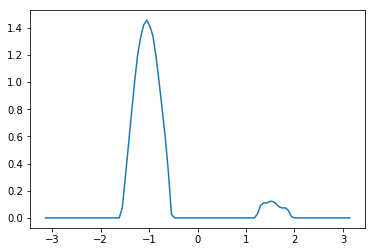

space done
96
space


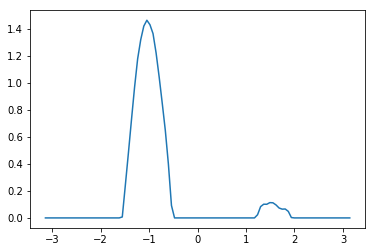

space done
97
space


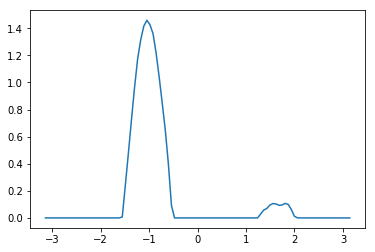

space done
98
space


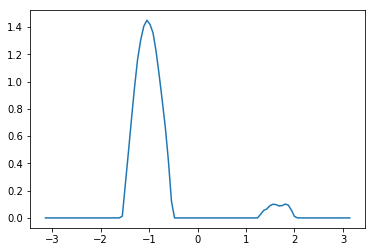

space done
99
space


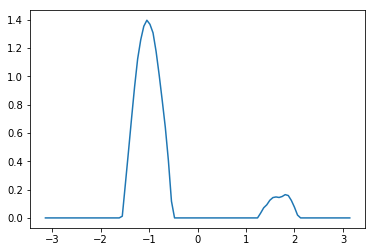

space done


In [4]:
steps = 100

for i in range(steps):
    print(i)
    H.propogate_by_amount(1) 

In [5]:
def periodizer(x):
    return (x- np.pi)%(2*np.pi)-np.pi


def intensity_H(time,space):
    t = np.array([H.temporal(time-item) for item in H.Events[0,:] if item < time])
    s = np.array([H.spatial(periodizer(space-item)) for item in H.Events[1,:] if H.Events[0,H.Events[1,:] == item] < time])
    return 0.5+ np.multiply(t,s).sum()


inten = np.vectorize(intensity_H)

In [6]:
import plotly
import plotly.graph_objs as go
import itertools
import numpy as np

time = np.linspace(0,H.Events[0,-1],200)
time = np.append(time, H.Events[0,:])
time.sort()

space = np.linspace(-np.pi,np.pi,200)
space = np.append(space, H.Events[1,:])
space.sort()

time_grid, space_grid = np.meshgrid(time, space, sparse = True)

z = inten(time_grid, space_grid)

In [7]:
data = [
    go.Surface(
        x = time,
        y = space,
        z=z
    )
]

layout = go.Layout(
    title='Parameter-surface',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
    
    
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='Parameter_surface_quot.html')


trace = [go.Heatmap(z=z,
                   x = time,
                   y = space,
                   colorscale = 'Jet'
                   ),
        go.Scatter(
        x = H.Events[0,:],
        y = H.Events[1,:],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(255, 182, 193, .9)',
            line = dict(
                width = 2,
                )
            )
        )        
]

layout = go.Layout(
    title='Space-Time Intensity Heatmap',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Space (Circle)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

data_heat= trace

fig = go.Figure(data=data_heat, layout=layout)

plotly.offline.plot(fig, filename='Heatmap_Hawkes_Process_intensity_with_scattered_Events_long.html')

'file:///home/jens/Dokumente/Hawkes-Processes/Spatio-Temporal-Hawkes-Proc-and-Appl/Spatio-Temporal-Hawkes-Proc-and-Appl/Heatmap_Hawkes_Process_intensity_with_scattered_Events_long.html'

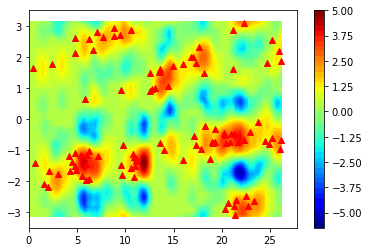

In [12]:
plt.contourf(time, space, z,50, cmap ='jet')
plt.colorbar()
plt.scatter(H.Events[0,:], H.Events[1,:], c= 'r',marker = '^')
